# Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Applied\ DL\ Music/

/content/drive/.shortcut-targets-by-id/1WiLGkdpFT7wl_snghM9azz5CzfomSCrF/Applied DL Music


In [3]:
!pip install pypianoroll

     |████████████████████████████████| 5.6 MB 19.3 MB/s 
     |████████████████████████████████| 51 kB 9.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=7aee9be1dcb2134fa228e21c2d31faee484349700c9ef7d3abd76a90259c0208
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [4]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

W: Operation was interrupted before it could finish
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__


In [ ]:
import pypianoroll
import IPython
import gc
import numpy as np

# Load datas

In [ ]:
import pickle as pkl
import numpy as np

with open('dataset_multracks.pkl', 'rb') as f:

  songs = pkl.load(f) # 22 secondes
f.close()

# Viz

In [2]:
# data viz
instruments = {'piano': 0, 'guitar': 0, 'bass': 0, 'strings': 0, 'drums': 0}
velocities = set()

for song in songs:

  for instrument in song.keys():

    if song[instrument] is not None:

      instruments[instrument] += song[instrument].shape[0] // 1024

      v = np.unique(song[instrument])
      for x in v:
        
        velocities.add(x)

print('instrument matrix count : {}\ndifferent velocities : {}'.format(instruments, velocities))

NameError: ignored

In [3]:
# data viz for vae training

datasets = {'piano': 0, 'guitar': 0, 'bass': 0, 'strings': 0, 'drums': 0}
datasets_zeros = {'piano': 0, 'guitar': 0, 'bass': 0, 'strings': 0, 'drums': 0}

window = 32

for song in songs:

  for instrument in song.keys():

    t = song[instrument]

    if t is not None:

      i = window

      while i < t.shape[0]:

        segment = t[i-window: i, :]
        if np.count_nonzero(segment) == 0:

          datasets_zeros[instrument] += 1
        
        else:
        
          datasets[instrument] += 1
        
        i += window

proportions_piano = datasets_zeros['piano'] / (datasets_zeros['piano'] + datasets['piano'])
proportions_guitar = datasets_zeros['guitar'] / (datasets_zeros['guitar'] + datasets['guitar'])
proportions_bass = datasets_zeros['bass'] / (datasets_zeros['bass'] + datasets['bass'])
proportions_strings = datasets_zeros['strings'] / (datasets_zeros['strings'] + datasets['strings'])
proportions_drums = datasets_zeros['drums'] / (datasets_zeros['drums'] + datasets['drums'])

print('proportions of empty matrix : \nPiano : {}\nGuitar : {}\nBass : {}\nStrings : {}\nDrums : {}'.format(proportions_piano, proportions_guitar, proportions_bass, proportions_strings, proportions_drums))
print('\n\nwished numbers of empty matrix to respect an empty matrix proportion of 0.1 : \nPiano : {}\nGuitar : {}\nBass : {}\nStrings : {}\nDrums : {}'.format(int((1/9) * datasets['piano']), int((1/9) * datasets['guitar']), int((1/9) * datasets['bass']), int((1/9) * datasets['strings']), int((1/9) * datasets['drums'])))
print('\n\nSize of dataset respecting an empty matrix proportion of 0.1 : \nPiano : {}\nGuitar : {}\nBass : {}\nStrings : {}\nDrums : {}'.format(int((10/9) * datasets['piano']), int((10/9) * datasets['guitar']), int((10/9) * datasets['bass']), int((10/9) * datasets['strings']), int((10/9) * datasets['drums'])))


NameError: ignored

In [ ]:
# data viz for melody training

datasets = {'piano': 0, 'guitar': 0, 'bass': 0, 'strings': 0, 'drums': 0}

for song in songs:

  for instrument in song.keys():

    t = song[instrument]

    if t is not None:

      dim = t.shape[0] // window - 1 # num of reccurent double sample window x 128
      datasets[instrument] += dim

print(datasets)

# Preprocessing

In [ ]:
# build dataset

from tqdm.notebook import tqdm_notebook

MAX_VELOCITY = 127
WINDOW = 256

def build_dataset(instrument):

  index = 0

  if instrument == 'piano':

    x = np.zeros((44966 + 4000, WINDOW, 128, 1), dtype=np.float16)
  
  elif instrument == 'guitar': 
    
    x = np.zeros((10995 + 1000, WINDOW, 128, 1), dtype=np.float16)
  
  elif instrument == 'bass':
    
    x = np.zeros((34248 + 3000, WINDOW, 128, 1), dtype=np.float16)
  
  elif instrument == 'strings':
    
    x = np.zeros((12213 + 1000, WINDOW, 128, 1), dtype=np.float16)
  
  elif instrument == 'drums':
    
    x = np.zeros((29402 + 3000, WINDOW, 128, 1), dtype=np.float16) 

  for song in tqdm_notebook(songs):

    t = np.expand_dims(song[instrument], axis=-1)

    if t is not None:

      i = WINDOW

      while i < t.shape[0]:

        segment = t[i-WINDOW: i, :, :]
        if np.count_nonzero(segment) != 0:

          x[index, :, :, :] = segment / MAX_VELOCITY

          index += 1
        
        i += WINDOW

  print('saving {} data at dataset_for_ae_{}.pkl ...'.format(instrument, instrument))
  with open('dataset_for_ae_{}.pkl'.format(instrument), 'wb') as f:

    pkl.dump(obj=x, file=f, protocol=4)

  f.close()
  print('succesfully saved datas !')

In [ ]:
build_dataset('piano')
build_dataset('guitar')
build_dataset('bass')
build_dataset('strings')
build_dataset('drums')

  0%|          | 0/1607 [00:00<?, ?it/s]

saving piano data at dataset_for_ae_piano.pkl ...
succesfully saved datas !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving guitar data at dataset_for_ae_guitar.pkl ...
succesfully saved datas !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving bass data at dataset_for_ae_bass.pkl ...
succesfully saved datas !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving strings data at dataset_for_ae_strings.pkl ...
succesfully saved datas !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving drums data at dataset_for_ae_drums.pkl ...
succesfully saved datas !


# baseline ae

In [6]:
import keras
import tensorflow as tf
from keras import Model
from keras import layers
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Dropout, Reshape, Flatten
from tensorflow.keras.backend import random_normal, squeeze     

In [7]:
WINDOW = 256
MAX_VELOCITY = 127

In [9]:
class AE(Model):

  def __init__(self, latent_space=128, window=WINDOW):
    super().__init__()

    ins = Input(shape=(window, 128, 1))
    x = Conv2D(1024, kernel_size=(4, 4), strides=(4, 4), activation='relu')(ins)
    x = Conv2D(512, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Conv2D(256, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Flatten()(x)

    z = Dense(latent_space)(x)

    x = Dense(256, activation='relu')(z)
    x = Reshape((1, 1, 256))(x)
    x = Conv2DTranspose(256, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Conv2DTranspose(512, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Conv2DTranspose(1024, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    outs = Conv2DTranspose(1, kernel_size=(4, 2), strides=(4, 2), activation='relu')(x)

    self.encoder = Model(ins, z, name='encoder')
    self.decoder = Model(z, outs, name='decoder')

    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="Reconstruction_loss"
    )
  
  def summary(self):

    self.encoder.summary()
    self.decoder.summary()
  
  def call(self, x):

    z = self.encoder(x)
    x = self.decoder(z)

    return x

  @property
  def metrics(self):
      return [
          self.reconstruction_loss_tracker
      ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    (data - reconstruction) ** 2, axis=(1, 2)
                )
            )
    grads = tape.gradient(reconstruction_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    return {
        "Reconstruction_loss": self.reconstruction_loss_tracker.result()
    }


In [10]:
import matplotlib.pyplot as plt
import numpy as np
  
def train_ae(instrument: str, train_gen, epochs: int):

  model = AE()
  model.summary()
  model.compile(optimizer='adam')
  history = model.fit(train_gen, epochs=epochs, shuffle=True)

  plt.title('Reconstruction_loss vs Epochs')
  plt.plot(history.history['Reconstruction_loss'])
  plt.ylabel('Reconstruction_loss')
  plt.xlabel('epoch')
  plt.show()

  print('saving model at models/{}_ae.hdf5 ...'.format(instrument))
  model.save_weights('models/{}_ae.hdf5'.format(instrument))
  print('succesfully saved model !')

  return model

In [11]:
def load_ae(instrument: str):

  model = AE()
  model.built = True
  print('loading model {}_ae ...'.format(instrument))
  model.load_weights('models/{}_ae.hdf5'.format(instrument))
  print('succesfully loaded model !')

  return model

In [12]:
def generate_sample_slice(model: Model, latent_vectors: np.ndarray):
  
  pred = model.decoder.predict(latent_vectors)

  return np.reshape(pred * MAX_VELOCITY, (latent_vectors.shape[0], WINDOW, 128)).astype(int)

In [13]:
def save_latent_vectors(ds, instrument):

  model = load_ae(instrument)
  
  print('saving {} latent vectors at latent_vectors/{}.pkl ...'.format(instrument, instrument))
  with open('latent_vectors/{}.pkl'.format(instrument), 'wb') as f:

    pkl.dump(model.encoder.predict(ds), f, protocol=4)
  
  f.close()
  print('succesfully saved datas !')

# piano ae

In [9]:
#load piano data

import pickle as pkl 

with open('dataset_for_ae_piano.pkl', 'rb') as f:

  x = pkl.load(f)
  np.random.shuffle(x)
f.close()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-d6a43ddf267c>", line 7, in <module>
    x = pkl.load(f)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped

KeyboardInterrupt: ignored

In [ ]:
print(x.shape)

(48966, 256, 128, 1)


In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x

train_gen = DataGenerator(x[:7800], 32)
test_gen = DataGenerator(x[-200:], 32)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 256, 128, 1)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 32, 1024)      17408     
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 8, 512)        8389120   
                                                                 
 conv2d_38 (Conv2D)          (None, 4, 2, 256)         2097408   
                                                                 
 flatten_13 (Flatten)        (None, 2048)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               262272    
                                                                 
Total params: 10,766,208
Trainable params: 10,766,208
Non-t

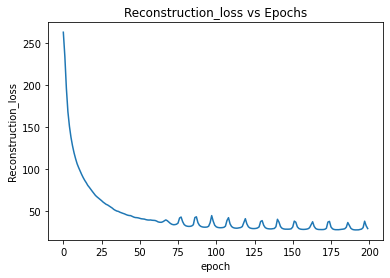

saving model at models/piano_ae.hdf5 ...
succesfully saved model !


In [ ]:
# train

model = train_ae('piano', train_gen, epochs=200)

loading model piano_ae ...
succesfully loaded model !


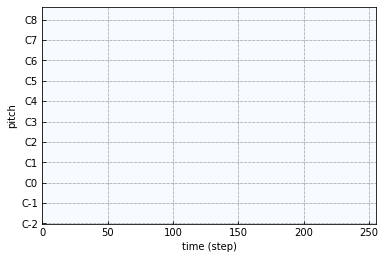

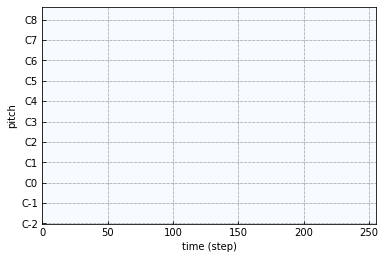

Start shape : (256, 128, 1)
End shape : (256, 128)


In [ ]:
# check training

model = load_ae('piano')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = train_gen.__getitem__(batch_nb)
x = x[matrix_nb]

piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(piano_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(piano_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

loading model piano_ae ...
succesfully loaded model !


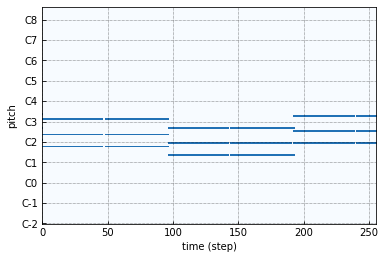

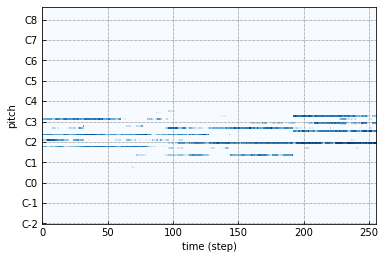

Start shape : (256, 128, 1)
End shape : (256, 128)


In [ ]:
# test

model = load_ae('piano')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = test_gen.__getitem__(batch_nb)
x = x[matrix_nb]

piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(piano_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(piano_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

# guitar ae

In [14]:
#load guitar data

import pickle as pkl 

with open('dataset_for_ae_guitar.pkl', 'rb') as f:

  x = pkl.load(f)
f.close()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-c2959c97f14f>", line 7, in <module>
    x = pkl.load(f)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 313, in wrappe

KeyboardInterrupt: ignored

In [ ]:
print(x.shape)

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x

train_gen = DataGenerator(x[:7800], 32)
test_gen = DataGenerator(x[-200:], 32)

In [ ]:
# train

model = train_ae('guitar', train_gen, epochs=200)

In [ ]:
# check training

model = load_ae('guitar')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = train_gen.__getitem__(batch_nb)
x = x[matrix_nb]

guitar_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(guitar_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

guitar_track = pypianoroll.StandardTrack(name='Guitar', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(guitar_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

In [ ]:
# test

model = load_ae('guitar')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = test_gen.__getitem__(batch_nb)
x = x[matrix_nb]

guitar_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(guitar_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

guitar_track = pypianoroll.StandardTrack(name='Guitar', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(guitar_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

# bass ae

In [ ]:
#load bass data

import pickle as pkl 

with open('dataset_for_ae_bass.pkl', 'rb') as f:

  x = pkl.load(f)
f.close()

In [ ]:
print(x.shape)

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x

train_gen = DataGenerator(x[:7800], 32)
test_gen = DataGenerator(x[-200:], 32)

In [ ]:
# train

model = train_ae('bass', train_gen, epochs=200)

In [ ]:
# check training

model = load_ae('bass')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = train_gen.__getitem__(batch_nb)
x = x[matrix_nb]

bass_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(bass_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

bass_track = pypianoroll.StandardTrack(name='Bass', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(bass_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

In [ ]:
# test

model = load_ae('bass')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = test_gen.__getitem__(batch_nb)
x = x[matrix_nb]

piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(piano_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

piano_track = pypianoroll.StandardTrack(name='Bass', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(piano_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

# strings ae

In [22]:
#load strings data

import pickle as pkl 

with open('dataset_for_ae_strings.pkl', 'rb') as f:

  x = pkl.load(f)
  np.random.shuffle(x)
f.close()

In [24]:
print(x.shape)

(13213, 256, 128, 1)


In [23]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x

train_gen = DataGenerator(x[:7800], 32)
test_gen = DataGenerator(x[-200:], 32)

In [ ]:
# train

model = train_ae('strings', train_gen, epochs=200)

loading model strings_ae ...
succesfully loaded model !


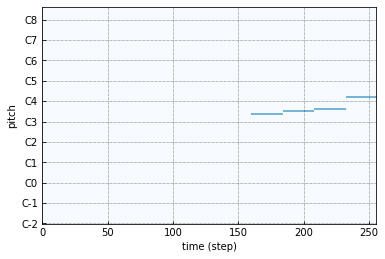

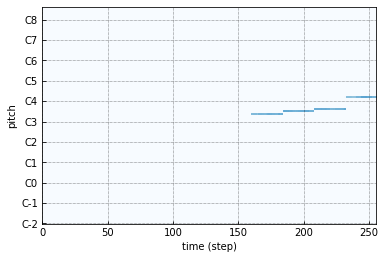

Start shape : (256, 128, 1)
End shape : (256, 128)


In [25]:
# check training

model = load_ae('strings')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = train_gen.__getitem__(batch_nb)
x = x[matrix_nb]

piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(piano_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

piano_track = pypianoroll.StandardTrack(name='Strings', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(piano_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

loading model strings_ae ...
succesfully loaded model !


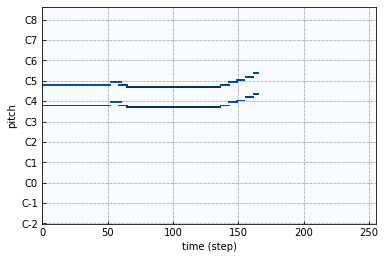

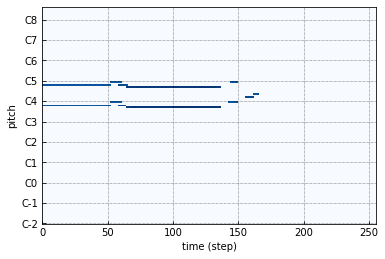

Start shape : (256, 128, 1)
End shape : (256, 128)


In [26]:
# test

model = load_ae('strings')
n = 90

batch_nb = n // 32
matrix_nb = n % 32

x = test_gen.__getitem__(batch_nb)
x = x[matrix_nb]

strings_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(strings_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

strings_track = pypianoroll.StandardTrack(name='Strings', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(strings_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

# drums ae

In [ ]:
#load drums data

import pickle as pkl 

with open('dataset_for_ae_drums.pkl', 'rb') as f:

  x = pkl.load(f)
f.close()

In [ ]:
print(x.shape)

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x

train_gen = DataGenerator(x[:7800], 32)
test_gen = DataGenerator(x[-200:], 32)

In [ ]:
# train

model = train_ae('drums', train_gen, epochs=200)

In [ ]:
# check training

model = load_ae('drums')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = train_gen.__getitem__(batch_nb)
x = x[matrix_nb]

drums_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(drums_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

drums_track = pypianoroll.StandardTrack(name='Drums', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(drums_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))

In [ ]:
# test

model = load_ae('drums')
n = 109

batch_nb = n // 32
matrix_nb = n % 32

x = test_gen.__getitem__(batch_nb)
x = x[matrix_nb]

drums_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=np.reshape((x * MAX_VELOCITY).astype(int), (WINDOW, 128)))
pypianoroll.plot(drums_track)
plt.show()

latent_vector = model.encoder.predict(np.expand_dims(x, axis=0))
new_window = generate_sample_slice(model, latent_vector)[0]

drums_track = pypianoroll.StandardTrack(name='Drums', program=0, is_drum=False, pianoroll=new_window)
pypianoroll.plot(drums_track)
plt.show()

print('Start shape : {}\nEnd shape : {}'.format(x.shape, new_window.shape))